# Demand Forecast on Visitor Count (Daily and Hourly)

Note:
1. We first implement time series prediction models including ARIMA, LSTM, XGBoost, and Prophet, and then choose the best one based on our evaluation matrix to maximize our prediction accuracy within the ability.
   
2. Due to the limitations of data source, we may expect large errors or less accuracy. Our aim is to find the best model as much as we could.
   
3. The prediction results will be generated on a weekly basis, saying the 7 days ahead, including the predicted visitor count for each day and for every operating hour in each day.

In [2]:
#import necessary libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import Hyperband
from tensorflow import keras

/var/folders/x4/_l78dvs92m346fbfkb6pl1h40000gn/T/ipykernel_78995/4016049148.py:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


#### Data Preparation

In [3]:
# Load visitor data
visitor_data = pd.read_csv("../data/raw/synthetic_visit_data.csv")
visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])
#visitor_data.head()

weather_data = pd.read_csv("../data/processed/weather_data_cleaned.csv")
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
columns_to_drop = weather_data.columns[0:3].tolist()  # Dropping columns by indices
weather_data.drop(columns=columns_to_drop, inplace=True)
#weather_data.head()

holiday_data = pd.read_csv("../data/raw/date_info_2324.csv")
holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
holiday_data.drop(columns="day_of_week", inplace=True)
#holiday_data.head()

merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
merged_data.drop(columns=["Date","calender_date","Highest 30 min Rainfall (mm)","Highest 60 min Rainfall (mm)","Highest 120 min Rainfall (mm)","Maximum Temperature (°C)","Minimum Temperature (°C)","Mean Wind Speed (km/h)","Max Wind Speed (km/h)"], inplace=True)
merged_data.head()

,day_of_week,visit_date,visitors,Daily Rainfall Total (mm),Mean Temperature (°C),holiday_flg_sg,holiday_flg_cn,holiday_flg_in
0,Sunday,2023-01-01,400,0.0,27.8,1,1,1
1,Monday,2023-01-02,280,4.0,27.5,1,1,1
2,Tuesday,2023-01-03,150,5.8,27.0,0,0,0
3,Wednesday,2023-01-04,120,0.0,27.1,0,0,0
4,Thursday,2023-01-05,110,38.6,26.4,0,0,0


At this stage, we have combined our three datasets to prepare for our analysis later. We will use "Daily Total Rainfall" and "Mean Temperature" for our feature engineering, and dropped other similar columns to reduce the amount of features.

#### Feature Engineering

In [4]:
# 1. Encoding Categorical Variables
df = pd.get_dummies(merged_data, columns=['day_of_week'])

# 2. Creating a binary feature for heavy rainfall
merged_data['heavy_rainfall_flg'] = (merged_data['Daily Rainfall Total (mm)'] > 20).astype(int)

# 3. Categorizing temperature
merged_data['temperature_category'] = pd.cut(df['Mean Temperature (°C)'],
                                    bins=[-np.inf, 15, 25, np.inf],
                                    labels=['cold', 'mild', 'hot'])

# 4. Consolidating Holiday Flags
merged_data['is_holiday'] = merged_data[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)

# 5. Adding week of the year
merged_data['week_of_year'] = pd.to_datetime(merged_data['visit_date']).dt.isocalendar().week

# It's essential to transform these new categorical variables into a form suitable for modeling
merged_data = pd.get_dummies(merged_data, columns=['temperature_category'])

merged_data.drop(columns=["Daily Rainfall Total (mm)","Mean Temperature (°C)", "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in"], inplace = True)
merged_data.head()

,day_of_week,visit_date,visitors,heavy_rainfall_flg,is_holiday,week_of_year,temperature_category_cold,temperature_category_mild,temperature_category_hot
0,Sunday,2023-01-01,400,0,1,52,0,0,1
1,Monday,2023-01-02,280,0,1,1,0,0,1
2,Tuesday,2023-01-03,150,0,0,1,0,0,1
3,Wednesday,2023-01-04,120,0,0,1,0,0,1
4,Thursday,2023-01-05,110,1,0,1,0,0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


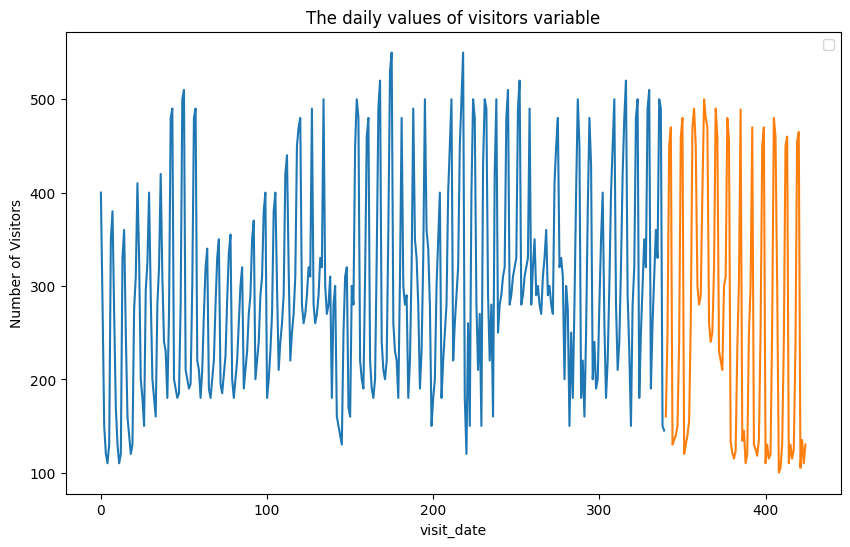

In [5]:
# Split the data into training and testing sets
train_percent = 0.8  # Use 80% of the data for training
split_index = int(len(merged_data) * train_percent)
train_data = visitor_data.iloc[:split_index]
test_data = visitor_data.iloc[split_index:]

# Convert the index (visit_date) to datetime
merged_data.index = pd.to_datetime(merged_data.index)

plt.figure(figsize=(10, 6))
plt.plot(train_data['visitors'])
plt.plot(test_data['visitors'])
plt.title('The daily values of visitors variable')
plt.xlabel('visit_date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

### ARIMA Model

1. Check for stationarity

In [8]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

check_stationarity(df['visitors'])

ADF Statistic: -4.540648893121901
p-value: 0.00016592835765189394
Series is stationary


2. Plotting ACF and PACF to determine order parameters of ARIMA Model (p,d,q)

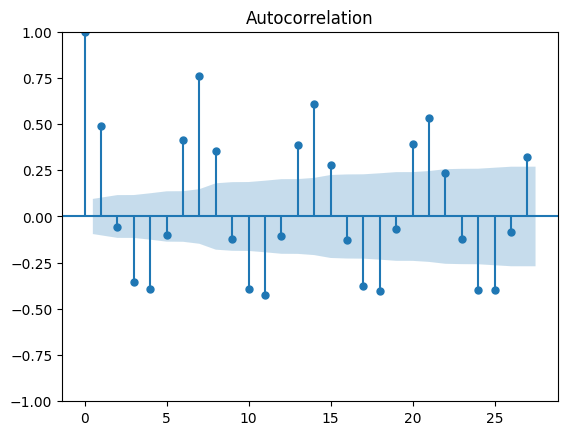

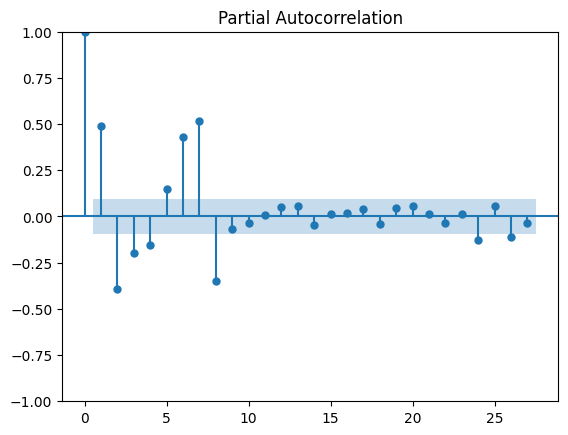

In [9]:
plot_acf(df['visitors'].dropna())
plot_pacf(df['visitors'].dropna())
plt.show()

ACF and PACF Plots: Use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine the potential values for q and p, respectively.

ACF Plot for q: The ACF plot shows the correlation of the series with its lags. In general, you're looking for the point where the ACF plot crosses the upper confidence interval for the first time. This point suggests a good starting value for q.

PACF Plot for p: The PACF plot shows the partial correlation of the series with its lags. You're looking for the point where the PACF plot crosses the upper confidence interval for the first time. This point is a good starting value for p.

From above plot, we shall try q = 1 and p = 1.

3. Model fitting

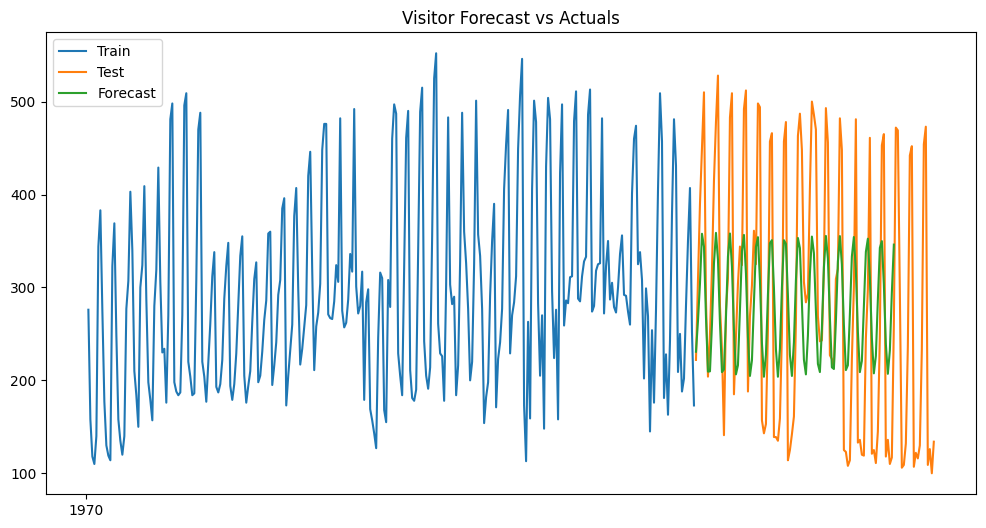

In [30]:
# Split data into train and test
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = ARIMA(train_data, order=(4,1,3))  # p, d, q to be chosen based on your ACF and PACF analysis
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=100)
forecast = pd.Series(forecast, index=test_data.index)

# Plotting the forecast against actual values
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Visitor Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

4. Fine-tuning hyperparameters using Grid Search

In [24]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")  # ignore warnings from ARIMA fitting

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(df['visitors'], order=param)
        results = mod.fit()
        
        # Compare current model's AIC with the best so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print('Best ARIMA{} AIC={}'.format(best_pdq, best_aic))

Best ARIMA(4, 1, 3) AIC=4848.416966864049


In [12]:
# Evaluate model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 75.89194339088861


#### LSTM

2024-04-16 14:21:08.869507: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-16 14:21:08.869566: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-16 14:21:08.869578: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-16 14:21:08.869621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-16 14:21:08.869637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Epoch 1/100


2024-04-16 14:21:09.682369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 - 2s - 496ms/step - loss: 0.2174 - val_loss: 0.2334
Epoch 2/100
5/5 - 0s - 40ms/step - loss: 0.1744 - val_loss: 0.1815
Epoch 3/100
5/5 - 0s - 35ms/step - loss: 0.1322 - val_loss: 0.1265
Epoch 4/100
5/5 - 0s - 37ms/step - loss: 0.0887 - val_loss: 0.0761
Epoch 5/100
5/5 - 0s - 34ms/step - loss: 0.0638 - val_loss: 0.0496
Epoch 6/100
5/5 - 0s - 33ms/step - loss: 0.0627 - val_loss: 0.0475
Epoch 7/100
5/5 - 0s - 34ms/step - loss: 0.0585 - val_loss: 0.0456
Epoch 8/100
5/5 - 0s - 33ms/step - loss: 0.0549 - val_loss: 0.0471
Epoch 9/100
5/5 - 0s - 33ms/step - loss: 0.0510 - val_loss: 0.0499
Epoch 10/100
5/5 - 0s - 34ms/step - loss: 0.0476 - val_loss: 0.0481
Epoch 11/100
5/5 - 0s - 33ms/step - loss: 0.0475 - val_loss: 0.0438
Epoch 12/100
5/5 - 0s - 33ms/step - loss: 0.0441 - val_loss: 0.0406
Epoch 13/100
5/5 - 0s - 33ms/step - loss: 0.0437 - val_loss: 0.0394
Epoch 14/100
5/5 - 0s - 33ms/step - loss: 0.0376 - val_loss: 0.0388
Epoch 15/100
5/5 - 0s - 33ms/step - loss: 0.0350 - val_loss: 0.0381


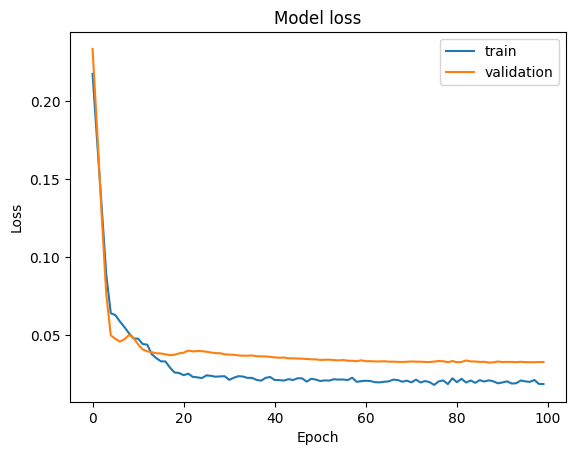

In [6]:
# Create lag features for visitors
for lag in range(1, 8):  # 7 days lag
    merged_data[f'visitors_lag_{lag}'] = merged_data['visitors'].shift(lag)

# Create rolling window features (7-day rolling mean and std deviation)
merged_data['rolling_mean_visitors'] = merged_data['visitors'].rolling(window=7).mean().shift(1)
merged_data['rolling_std_visitors'] = merged_data['visitors'].rolling(window=7).std().shift(1)

# Fill any NaN values that have been introduced by lag/rolling features
merged_data.fillna(method='bfill', inplace=True)

merged_data['year'] = merged_data['visit_date'].dt.year
merged_data['month'] = merged_data['visit_date'].dt.month
merged_data['day'] = merged_data['visit_date'].dt.day
lstm_data = merged_data.drop(['visit_date','day_of_week'], axis=1, inplace=False)
X = lstm_data.drop(['visitors'], axis=1)
y = lstm_data['visitors']
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Select features and target
X = lstm_data.drop(['visitors'], axis=1)
y = lstm_data['visitors']

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

# Reshape for LSTM [samples, time steps, features]
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the LSTM model with dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=2)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict and inverse transform predictions
predictions = model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)

# Inversely transform y_test for comparison
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f'Test RMSE: {rmse:.3f}')

# Plot predictions against actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_model = tuner.get_best_models(num_models=1)[0]
loss = best_model.evaluate(X_test, y_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Test RMSE: 67.932


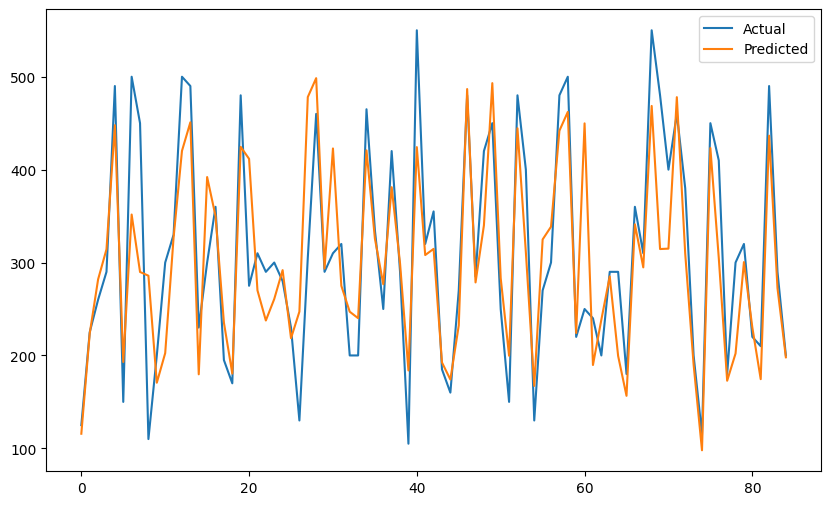

In [7]:
# Predict and inverse transform predictions
predictions = model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)

# Inversely transform y_test for comparison
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f'Test RMSE: {rmse:.3f}')

# Plot predictions against actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_model = tuner.get_best_models(num_models=1)[0]
loss = best_model.evaluate(X_test, y_test)

#### tuning hyperparameters using hyperband

Trial 29 Complete [00h 00m 06s]
val_loss: 0.048629358410835266

Best val_loss So Far: 0.04423169791698456
Total elapsed time: 00h 02m 19s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
100               |150               |units1
0.3               |0.2               |dropout1
80                |60                |units2
0.4               |0.1               |dropout2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

Best ARIMA order: (5, 1, 3) with AIC: 3814.6180648499712


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


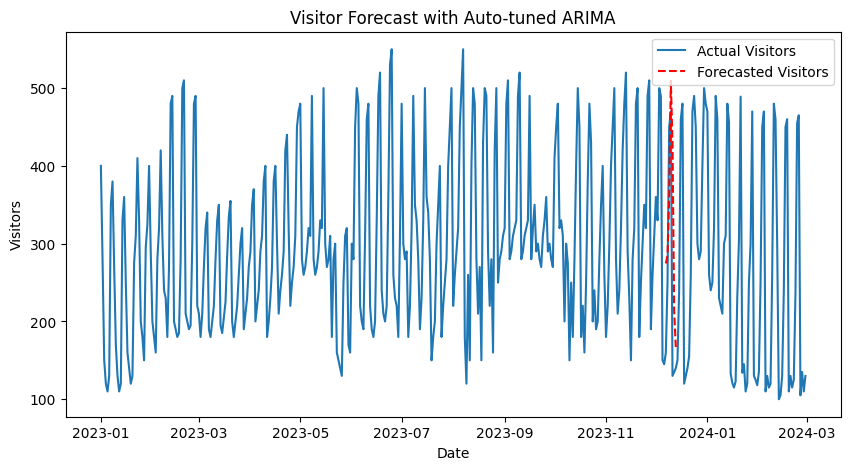

Forecasted Visitors for the next 7 days:
2023-12-07: 274.56
2023-12-08: 284.73
2023-12-09: 359.21
2023-12-10: 509.33
2023-12-11: 429.12
2023-12-12: 213.45
2023-12-13: 167.05


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import itertools
import warnings
from kerastuner.tuners import RandomSearch


def prepare_data(visitor_data_path, weather_data_path, holiday_data_path):
    visitor_data = pd.read_csv("../data/raw/synthetic_visit_data.csv")
    visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])

    weather_data = pd.read_csv("../data/processed/weather_data_cleaned.csv")
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    weather_data.drop(columns=weather_data.columns[0:3], inplace=True)

    holiday_data = pd.read_csv("../data/raw/date_info_2324.csv")
    holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
    holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
    holiday_data.drop(columns="day_of_week", inplace=True)

    merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
    merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
    merged_data.drop(columns=["Date", "calender_date"], inplace=True)

    df = pd.get_dummies(merged_data, columns=['day_of_week'])
    df['heavy_rainfall_flg'] = (df['Daily Rainfall Total (mm)'] > 20).astype(int)
    df['temperature_category'] = pd.cut(df['Mean Temperature (°C)'],
                                        bins=[-np.inf, 15, 25, np.inf],
                                        labels=['cold', 'mild', 'hot'])
    df['is_holiday'] = df[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)
    df['week_of_year'] = df['visit_date'].dt.isocalendar().week
    df = pd.get_dummies(df, columns=['temperature_category'])
    df.drop(columns=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in"], inplace=True)

    return df

def auto_tune_arima(train_data, p_range, d_range, q_range, seasonal=False):
    """
    Automatically tunes the ARIMA parameters based on the lowest AIC.
    
    Parameters:
    - train_data: The training data series.
    - p_range: Range of values for the AR parameter.
    - d_range: Range of values for the differencing parameter.
    - q_range: Range of values for the MA parameter.
    - seasonal: If True, will use SARIMA (Seasonal ARIMA).
    
    Returns:
    - A tuple of the best model and its parameters.
    """
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                if seasonal:
                    # For seasonal, you can extend this to include seasonal order
                    pass
                else:
                    try:
                        model = ARIMA(train_data, order=(p, d, q))
                        results = model.fit()
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (p, d, q)
                            best_model = results
                    except Exception as e:
                        continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_model, best_order

def forecast_visitors_arima(df, forecast_days=7):
    # Ensure 'df' is sorted by date if not already
    df.sort_values('visit_date', inplace=True)
    
    # Assuming 'visitors' is your target variable and exists in 'df'
    # Convert 'visit_date' to datetime index (if not already done)
    df.set_index('visit_date', inplace=True)
    train_data, _ = train_test_split(df['visitors'], test_size=0.2, shuffle=False)
    
    # Tune the ARIMA parameters (p, d, q ranges are examples, adjust as needed)
    p_range = range(0, 6)
    d_range = range(0, 6)
    q_range = range(0, 6)
    best_model, best_order = auto_tune_arima(train_data, p_range, d_range, q_range)
    
    # Forecast using the best model
    forecast = best_model.forecast(steps=forecast_days)
    
    # Generate future dates starting the day after the last date in 'train_data'
    last_date = train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(df['visitors'], label='Actual Visitors')
    plt.plot(future_dates, forecast, label='Forecasted Visitors', linestyle='--', color='red')
    plt.title('Visitor Forecast with Auto-tuned ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Visitors')
    plt.legend()
    plt.show()

    # Printing forecast values
    print("Forecasted Visitors for the next 7 days:")
    for date, value in zip(future_dates, forecast):
        print(f"{date.date()}: {value:.2f}")

    return forecast

# Example usage
# Ensure you replace 'path_to_your_data.csv' with the actual path to your CSV files
df = prepare_data('path_to_synthetic_visit_data.csv', 'path_to_weather_data_cleaned.csv', 'path_to_date_info_2324.csv')
forecast = forecast_visitors_arima(df, 7)

# Load and use the saved model
#model_fit = pickle.load(open('visitor_forecast_arima_model.pkl', 'rb'))
#new_forecast = model_fit.forecast(steps=7)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch

# Data Preparation Function
def prepare_data(visitor_data_path, weather_data_path, holiday_data_path):
    # Load and preprocess visitor data
    visitor_data = pd.read_csv(visitor_data_path)
    visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])

    # Load and preprocess weather data
    weather_data = pd.read_csv(weather_data_path)
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    weather_data.drop(columns=weather_data.columns[0:3], inplace=True)

    # Load and preprocess holiday data
    holiday_data = pd.read_csv(holiday_data_path)
    holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
    holiday_data.rename(columns={'calendar_date': 'calendar_date'}, inplace=True)
    holiday_data.drop(columns="day_of_week", inplace=True)

    # Merge datasets
    merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
    merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calendar_date', how='left')
    merged_data.drop(columns=["Date", "calendar_date"], inplace=True)

    # Feature engineering
    merged_data = pd.get_dummies(merged_data, columns=['day_of_week'])
    merged_data['heavy_rainfall_flag'] = (merged_data['Daily Rainfall Total (mm)'] > 20).astype(int)
    merged_data['temperature_category'] = pd.cut(merged_data['Mean Temperature (°C)'], bins=[-np.inf, 15, 25, np.inf], labels=['cold', 'mild', 'hot'])
    merged_data['is_holiday'] = merged_data[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)
    merged_data['week_of_year'] = merged_data['visit_date'].dt.isocalendar().week
    merged_data = pd.get_dummies(merged_data, columns=['temperature_category'])
    merged_data.drop(columns=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in"], inplace=True)
    
    merged_data['day_of_week'] = merged_data['visit_date'].dt.dayofweek
    merged_data['month'] = merged_data['visit_date'].dt.month
    merged_data.drop(columns=['visit_date'], inplace=True)
    
    return merged_data.reset_index(drop=True)

# Feature Engineering Function
def create_features(df, look_back=1):
    df['visitors'] = df[['visitors']].shift(-look_back)
    df.dropna(inplace=True)
    return df

# Data Scaling and Splitting Function
def scale_split_data(df):
    df_values = df.values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df_values)
    
    train_size = int(len(scaled) * 0.8)
    train, test = scaled[:train_size, :], scaled[train_size:, :]
    return train, test, scaler

# Dataset Preparation Function for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :-1]  # Selecting all features except the target variable for sequence
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Assuming the target variable is the last column
    return np.array(X), np.array(Y)

# Updated LSTM Model Building Function to include look_back parameter

def build_lstm_model(hp, look_back, num_features):
    model = Sequential([
        Input(shape=(look_back, num_features)),  # Define the input shape explicitly with an Input layer
        LSTM(hp.Int('units', min_value=50, max_value=200, step=50)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



# Updated LSTM Model Tuning Function to include look_back
def tune_lstm_model(trainX, trainY, look_back, num_features):
    tuner = RandomSearch(
        lambda hp: build_lstm_model(hp, look_back=look_back, num_features=num_features),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=3,
        directory='lstm_tuning',
        project_name='visitor_forecast'
    )

    tuner.search(trainX, trainY, epochs=5, validation_split=0.2, verbose=2)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    model = tuner.hypermodel.build(best_hps)
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    return model


# Forecasting Function
def forecast_lstm(model, scaler, look_back, last_data):
    predictions = []
    current_batch = last_data.reshape((1, look_back, -1))
    for i in range(7):
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Main Execution Block
if __name__ == "__main__":
    # Adjust these paths to your datasets
    visitor_data_path = "../data/raw/synthetic_visit_data.csv"
    weather_data_path = "../data/processed/weather_data_cleaned.csv"
    holiday_data_path = "../data/raw/date_info_2324.csv"

    # Data preparation and feature engineering
    df = prepare_data(visitor_data_path, weather_data_path, holiday_data_path)
    look_back = 1
    df = create_features(df, look_back)
    train, test, scaler = scale_split_data(df)
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Model building, tuning, and forecasting
    num_features = 11  # This should be the number of columns in your dataset minus the target variable column
    model = tune_lstm_model(trainX, trainY, look_back, num_features)
    last_data = test[-look_back:, :-1]  # Exclude the target variable
    predictions = forecast_lstm(model, scaler, look_back, last_data)

    # Plotting the forecast
    plt.figure(figsize=(10,6))
    plt.plot(predictions, label='Forecasted Visitors')
    plt.title('Visitor Forecast with LSTM')
    plt.xlabel('Day')
    plt.ylabel('Visitors')
    plt.legend()
    plt.show()

    # Print the forecasted visitor numbers
    print("Forecasted Visitors for the next 7 days:")
    for i, prediction in enumerate(predictions, 1):
        print(f"Day {i}: {prediction[0]:.2f}")


Reloading Tuner from lstm_tuning/visitor_forecast/tuner0.json

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
150               |50                |units



2024-04-11 15:48:26.436227: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-11 15:48:26.436256: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-11 15:48:26.436261: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-11 15:48:26.436281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 15:48:26.436295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2024-04-11 15:48:26.895768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


: 